In [1]:
%matplotlib inline
import numpy as np
import os
from evaluate_tools import evaluate,plot_confusion_matrix
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
cnn_prob_file='../result/cnn_prob.csv'
tscnn_prob_file='../result/tscnn_prob.csv'
yolo_prob_file='../result/yolo_prob.csv'
tsyolo_prob_file='../result/tsyolo_prob.csv'

Using TensorFlow backend.


In [2]:
def read_probs():
    probs={}
    
    with open(cnn_prob_file) as f:
        next(f)
        lines=f.readlines()
    for line in lines:
        data=line.replace("\n","").split(",")
        fn=data[0].split("/")[4].replace(".txt","").replace(".jpg","")
        if fn not in probs:
            probs[fn]={}
            probs[fn]["real"]=float(data[1])
        probs[fn]["cnn"]={}
        probs[fn]["cnn"]["prob"]=np.asarray([float(i) for i in data[2:5]])
        probs[fn]["cnn"]["result"]=np.argmax(probs[fn]["cnn"]["prob"])
            
    with open(tscnn_prob_file) as f:
        next(f)
        lines=f.readlines()
    for line in lines:
        data=line.replace("\n","").split(",")
        fn=data[0].split("/")[4].replace(".txt","").replace(".jpg","")
        if fn not in probs:
            probs[fn]={}
            probs[fn]["real"]=float(data[1])
        probs[fn]["tscnn"]={}
        probs[fn]["tscnn"]["prob"]=np.asarray([float(i) for i in data[2:5]])
        probs[fn]["tscnn"]["result"]=np.argmax(probs[fn]["tscnn"]["prob"])
    
    with open(yolo_prob_file) as f:
        next(f)
        lines=f.readlines()
    for line in lines:
        data=line.replace("\n","").split(",")
        fn=data[0].split("/")[4].replace(".txt","").replace(".jpg","")
        if fn not in probs:
            probs[fn]={}
            probs[fn]["real"]=float(data[1])
        probs[fn]["yolo"]={}
        probs[fn]["yolo"]["prob"]=np.asarray([float(i) for i in data[2:5]])
        probs[fn]["yolo"]["result"]=np.argmax(probs[fn]["yolo"]["prob"])
            
    with open(tsyolo_prob_file) as f:
        next(f)
        lines=f.readlines()
    for line in lines:
        data=line.replace("\n","").split(",")
        fn=data[0].split("/")[4].replace(".txt","").replace(".jpg","")
        if fn not in probs:
            probs[fn]={}
            probs[fn]["real"]=float(data[1])
        probs[fn]["tsyolo"]={}
        probs[fn]["tsyolo"]["prob"]=np.asarray([float(i) for i in data[2:5]])
        probs[fn]["tsyolo"]["result"]=np.argmax(probs[fn]["tsyolo"]["prob"])
    
    return probs

In [3]:
probs=read_probs()

## Voting


SCOREs
+-------+-----------+--------+--------+---------+
| Label | Precision | Recall | FScore | Support |
+=======+===========+========+========+=========+
| 0     | 0.857     | 0.764  | 0.808  | 110     |
+-------+-----------+--------+--------+---------+
| 1     | 0.754     | 0.836  | 0.793  | 110     |
+-------+-----------+--------+--------+---------+
| 2     | 0.964     | 0.964  | 0.964  | 110     |
+-------+-----------+--------+--------+---------+


 CONFUSION MATRIX
[[0.76363636 0.23636364 0.        ]
 [0.12727273 0.83636364 0.03636364]
 [0.         0.03636364 0.96363636]]


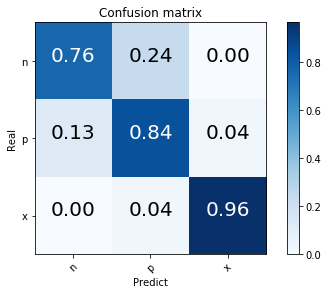

In [4]:
def voting_a(probs):
    true=[]
    pred=[]
    for k in sorted(probs,key=lambda k:probs[k]["real"]):
        true_value=probs[k]["real"]
        pred_value=[probs[k]["cnn"]["result"],probs[k]["tscnn"]["result"],probs[k]["yolo"]["result"],probs[k]["tsyolo"]["result"]]
        true.append(true_value)
        if pred_value.count(1)>=2:
            pred.append(1)
        elif pred_value.count(2)>=2:
            pred.append(2)
        else:
            pred.append(0)
    return np.asarray(true),np.asarray(pred)
t,p=voting_a(probs)
evaluate(t,p)
plot_confusion_matrix(t,p,["n","p","x"])

## Voting by weight


SCOREs
+-------+-----------+--------+--------+---------+
| Label | Precision | Recall | FScore | Support |
+=======+===========+========+========+=========+
| 0     | 0.874     | 0.755  | 0.810  | 110     |
+-------+-----------+--------+--------+---------+
| 1     | 0.752     | 0.855  | 0.800  | 110     |
+-------+-----------+--------+--------+---------+
| 2     | 0.964     | 0.964  | 0.964  | 110     |
+-------+-----------+--------+--------+---------+


 CONFUSION MATRIX
[[0.75454545 0.24545455 0.        ]
 [0.10909091 0.85454545 0.03636364]
 [0.         0.03636364 0.96363636]]


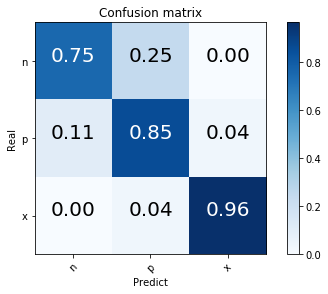

In [91]:
def voting_w(probs):
    true=[]
    pred=[]
    for k in sorted(probs,key=lambda k:probs[k]["real"]):
        true_value=probs[k]["real"]
        pred_value=([probs[k]["cnn"]["result"],probs[k]["tscnn"]["result"],probs[k]["yolo"]["result"],probs[k]["tsyolo"]["result"]])
        votes=[0,0,0]
        weight=[
            #[1,2,1],[1,3,1],[2,2,1],[1,2,4]
                [1,1,1],
                [1,2,1],
                [1,1,1],
                [1,1,2]     
        ]
        for i,p in enumerate(pred_value):
            for r in range(3):
                if p==r:
                    votes[r]+=weight[i][r]
        #votes=([votes[i]/sum(weight[k][i] for k in range(4)) for i in range(3) ])
        if votes[1]>=votes[0] and votes[1]>=votes[2]:
            pred.append(1)
        else:
            if votes[2]>votes[0]:
                pred.append(2)
            else:
                pred.append(0)
        #pred.append(np.argmax(np.asarray(votes)))
#         if votes[1]>=4:
#             pred.append(1)
#         elif votes[2]>=2:
#             pred.append(2)
#         else:
#             pred.append(0)
        true.append(true_value)
    return np.asarray(true),np.asarray(pred)
t,p=voting_w(probs)
evaluate(t,p)
plot_confusion_matrix(t,p,["n","p","x"])

## Sum of probability


SCOREs
+-------+-----------+--------+--------+---------+
| Label | Precision | Recall | FScore | Support |
+=======+===========+========+========+=========+
| 0     | 0.856     | 0.755  | 0.802  | 110     |
+-------+-----------+--------+--------+---------+
| 1     | 0.764     | 0.855  | 0.807  | 110     |
+-------+-----------+--------+--------+---------+
| 2     | 0.973     | 0.973  | 0.973  | 110     |
+-------+-----------+--------+--------+---------+


 CONFUSION MATRIX
[[0.75454545 0.24545455 0.        ]
 [0.11818182 0.85454545 0.02727273]
 [0.00909091 0.01818182 0.97272727]]


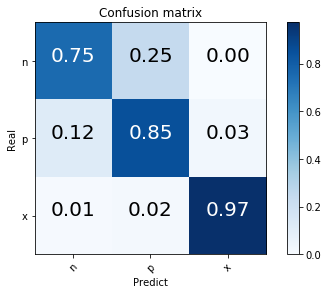

In [6]:
def probSum(probs,positive_thresh=2):
    true=[]
    pred=[]
    for k in sorted(probs,key=lambda k:probs[k]["real"]):
        true_value=probs[k]["real"]
        pred_probs=[probs[k]["cnn"]["prob"],probs[k]["tscnn"]["prob"],probs[k]["yolo"]["prob"],probs[k]["tsyolo"]["prob"]]
        true.append(true_value)
        pred_value=np.sum(np.asarray(pred_probs),axis=0)
        if pred_value[1]>positive_thresh:
            pred.append(1)
        else:
            pred.append(np.argmax(pred_value))
        #print(true[-1],pred_value,pred[-1])
    return np.asarray(true),np.asarray(pred)
t,p=probSum(probs,1.5)
evaluate(t,p)
plot_confusion_matrix(t,p,["n","p","x"])

## Sum of weited prob


SCOREs
+-------+-----------+--------+--------+---------+
| Label | Precision | Recall | FScore | Support |
+=======+===========+========+========+=========+
| 0     | 0.950     | 0.691  | 0.800  | 110     |
+-------+-----------+--------+--------+---------+
| 1     | 0.739     | 0.927  | 0.823  | 110     |
+-------+-----------+--------+--------+---------+
| 2     | 0.964     | 0.982  | 0.973  | 110     |
+-------+-----------+--------+--------+---------+


 CONFUSION MATRIX
[[0.69090909 0.30909091 0.        ]
 [0.03636364 0.92727273 0.03636364]
 [0.         0.01818182 0.98181818]]


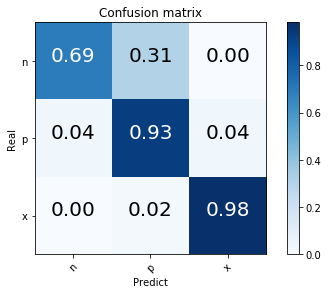

In [64]:
def probSumWeight(probs,positive_thresh=2):
    true=[]
    pred=[]
    for k in sorted(probs,key=lambda k:probs[k]["real"]):
        true_value=probs[k]["real"]
        prob=[probs[k]["cnn"]["prob"],probs[k]["tscnn"]["prob"],probs[k]["yolo"]["prob"],probs[k]["tsyolo"]["prob"]]
        prob=np.asarray(prob)
        weight_matrix=np.asarray(
            [
#                 [1,2,1],
#                 [1,3,1],
#                 [2,2,1],
#                 [1,2,4]
                [4,1,1],
                [1,4,1],
                [2,2,2],
                [1,1,4]
            ]
        )
        pred_value=np.sum(prob*weight_matrix,axis=0)
        #pred_value=pred_value/np.sum(weight_matrix,axis=0)
        true.append(true_value)
        pred.append(np.argmax(pred_value))
        #print(true[-1],pred_value,pred[-1])
    return np.asarray(true),np.asarray(pred)
t,p=probSumWeight(probs,1.5)
evaluate(t,p)
plot_confusion_matrix(t,p,["n","p","x"])

## DC Tree


SCOREs
+-------+-----------+--------+--------+---------+
| Label | Precision | Recall | FScore | Support |
+=======+===========+========+========+=========+
| 0     | 0.762     | 0.800  | 0.780  | 20      |
+-------+-----------+--------+--------+---------+
| 1     | 0.792     | 0.704  | 0.745  | 27      |
+-------+-----------+--------+--------+---------+
| 2     | 0.857     | 0.947  | 0.900  | 19      |
+-------+-----------+--------+--------+---------+


 CONFUSION MATRIX
[[0.8        0.2        0.        ]
 [0.18518519 0.7037037  0.11111111]
 [0.         0.05263158 0.94736842]]


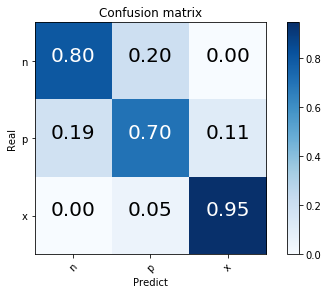

In [54]:
from sklearn import tree
from sklearn.model_selection import train_test_split
clf=tree.DecisionTreeClassifier()
x=[]
y=[]
for k,v in probs.items():
    y.append(v["real"])
    x.append(np.concatenate((v["cnn"]["prob"],v["tscnn"]["prob"],v["yolo"]["prob"],v["tsyolo"]["prob"])))
x=np.asarray(x)
y=np.asarray(y)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
m=clf.fit(X_train,y_train)
y_pred=m.predict(X_test)
y_predict=m.predict(x)
evaluate(y_test,y_pred)
plot_confusion_matrix(y_test,y_pred,["n","p","x"])